In [1]:
import torch
import numpy as np
from plot_manager import PlotManager
from dataset import build_dataloaders
from bilstm import BiLSTMAttentionClassifier
from attention_inspector import AttentionInspector

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttentionClassifier(
    pc_vocab=9,
    acc_vocab=10,
    oct_vocab=7,
    dur_vocab=33,
    meas_vocab=4,
    emb_dim=32,
    lstm_hidden=128,
    num_classes=12,
    dropout=0.3
)
model.to(device)
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print("Loaded best model from epoch:", checkpoint["epoch"])

_, _, _, test_loader = build_dataloaders(
    "vocab.pkl", "dataset.pkl", batch_size=8)

Loaded best model from epoch: 15


In [3]:
ai = AttentionInspector(device, model, test_loader)

In [4]:
(
    all_labels,
    all_preds,
    all_f_names,
    all_attn_weights,
    all_true_lengths,
    all_pcs,
    all_accs,
    all_meas,
    all_durs
) = ai.get_predictions()

In [5]:
(
    makam_vocab,
    makam_vocab_inv,
    pc_vocab,
    pc_vocab_inv,
    acc_vocab,
    acc_vocab_inv,
    dur_vocab,
    dur_vocab_inv
) = ai.export_vocabs()

In [6]:
makam_names = makam_vocab.keys()

In [7]:
results = ai.evaluate_classification(all_labels, all_preds, makam_names)

                 precision    recall  f1-score   support

          hicaz     1.0000    1.0000    1.0000        27
       nihavent     1.0000    1.0000    1.0000        18
          ussak     0.8000    0.8571    0.8276        14
           rast     0.9231    1.0000    0.9600        12
         huzzam     0.9444    1.0000    0.9714        17
          segah     0.9545    0.9545    0.9545        22
        huseyni     0.8182    0.8182    0.8182        11
          mahur     1.0000    0.9474    0.9730        19
       hicazkar     1.0000    1.0000    1.0000        11
kurdilihicazkar     1.0000    1.0000    1.0000         6
       muhayyer     1.0000    0.7778    0.8750         9
           saba     1.0000    1.0000    1.0000         9

       accuracy                         0.9543       175
      macro avg     0.9534    0.9463    0.9483       175
   weighted avg     0.9562    0.9543    0.9542       175



In [8]:
pm = PlotManager()

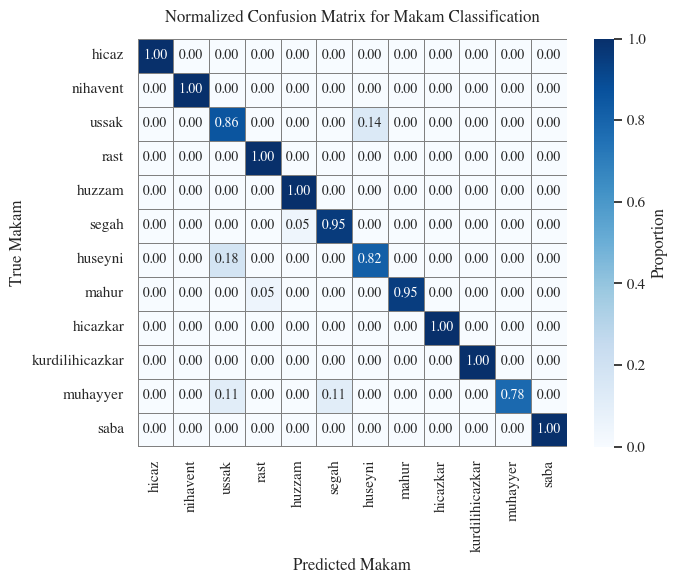

In [9]:
pm.plot_confusion_matrix(
    results["confusion_matrix"],
    makam_vocab.keys(),
    title="Normalized Confusion Matrix for Makam Classification",
    save_fig=False
)

In [10]:
i = 41  # index of the piece in the test set

(
    attn_piece,
    pcs_piece,
    accs_piece,
    meas_piece,
    durs_piece
) = ai.get_single_piece_ai(i)

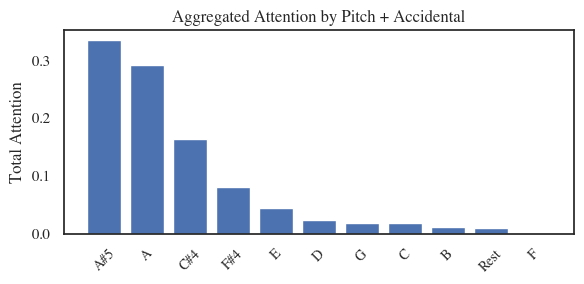

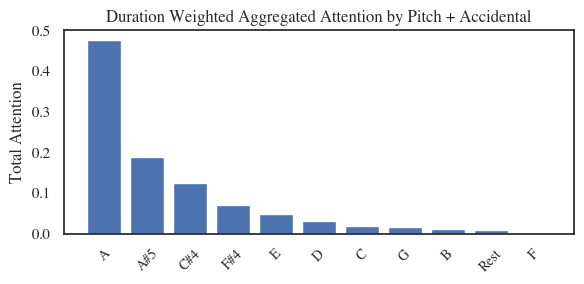

Attention-Duration correlation: 0.07995050260532174


In [11]:
agg_pitch_acc = ai.aggregate_attention_by_pitch_acc(
    attn_piece, pcs_piece, accs_piece)
agg_pitch_acc = ai.normalize_attention(agg_pitch_acc)
pm.plot_agg_attention_by_pitch(agg_pitch_acc, ai)

agg_duration = ai.aggregate_attention_pitch_acc_duration(
    attn_piece, pcs_piece, accs_piece, durs_piece
)
agg_duration = ai.normalize_attention(agg_duration)

pm.plot_agg_attention_by_pitch_duration(agg_duration, ai)

avg_corr = ai.get_mean_attn_dur_correlation("hicaz")

print("Attention-Duration correlation:", avg_corr)

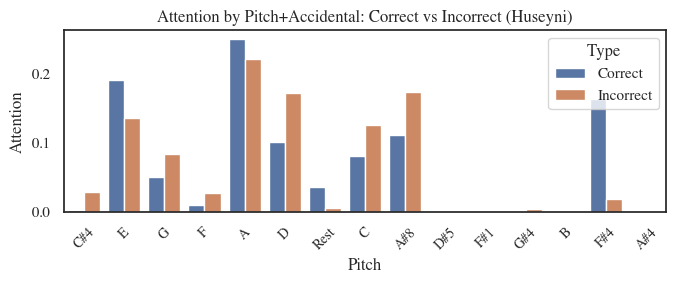

Entropy (Correct): 1.99711690407259
Entropy (Incorrect): 2.027367275992545


In [12]:
makam = "huseyni"
pm.plot_agg_attention_correct_vs_incorrect(makam, ai)

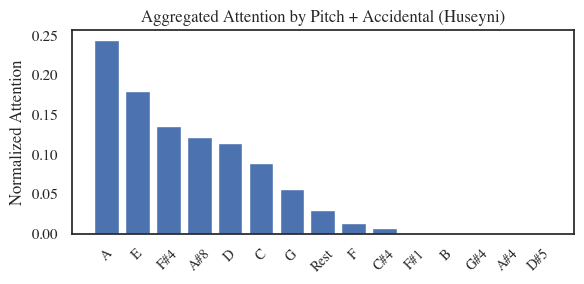

In [13]:
pm.plot_agg_attention_by_pitch_duration_makam("huseyni", ai)

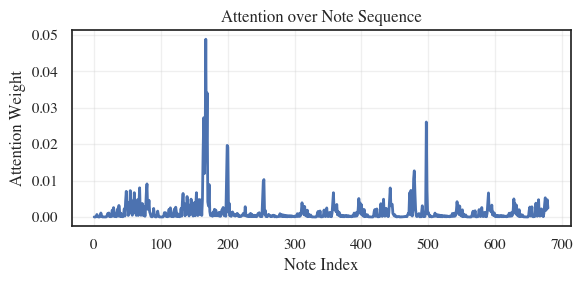

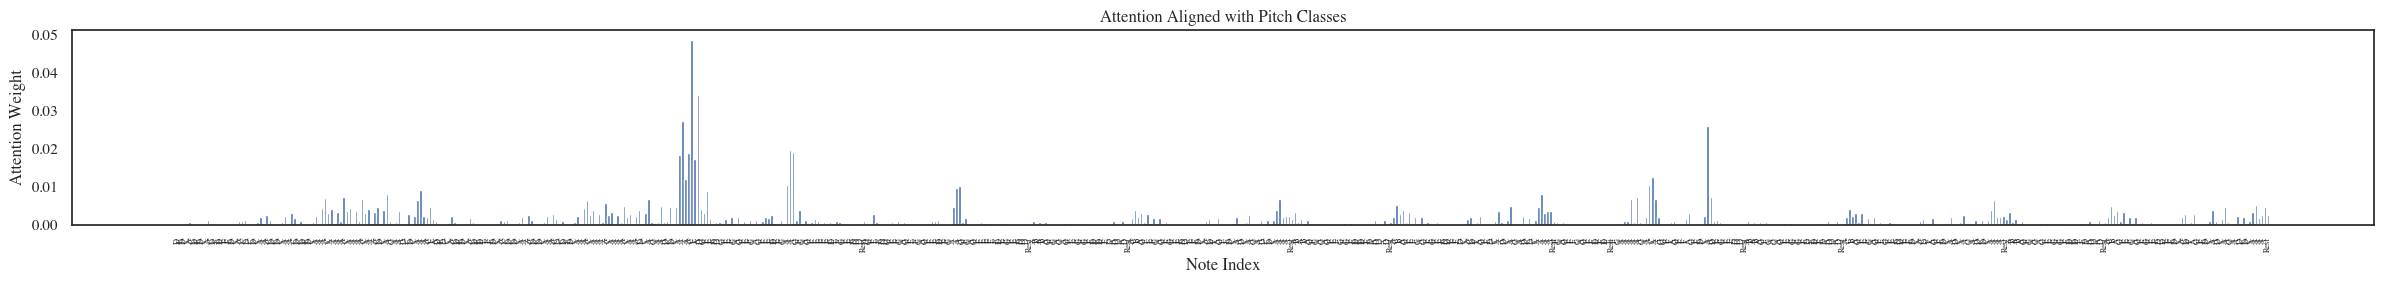

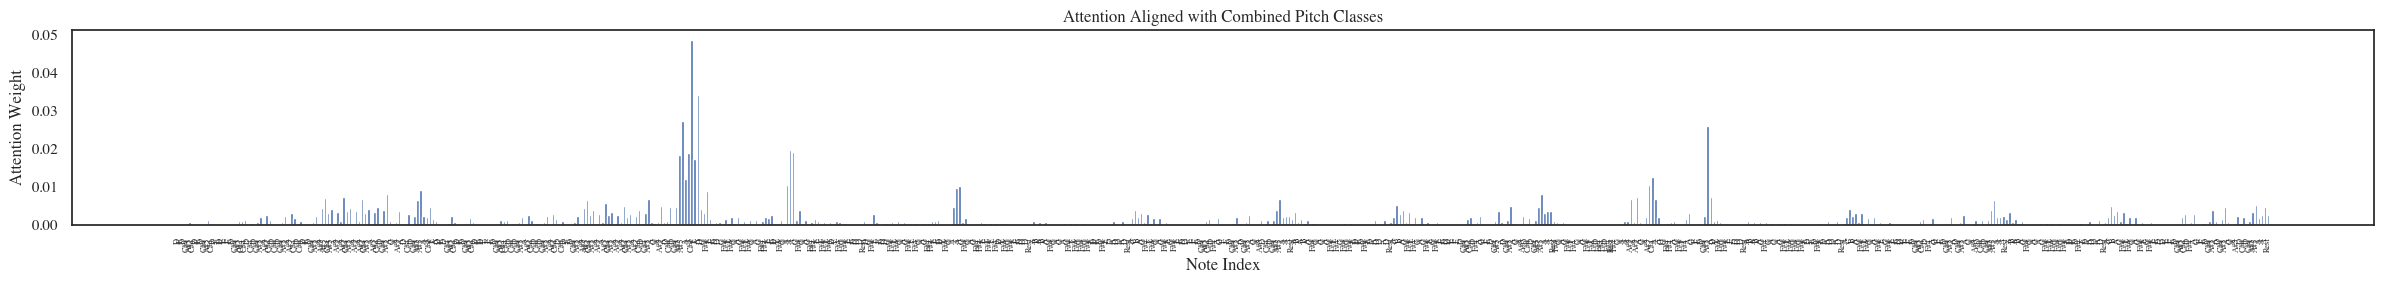

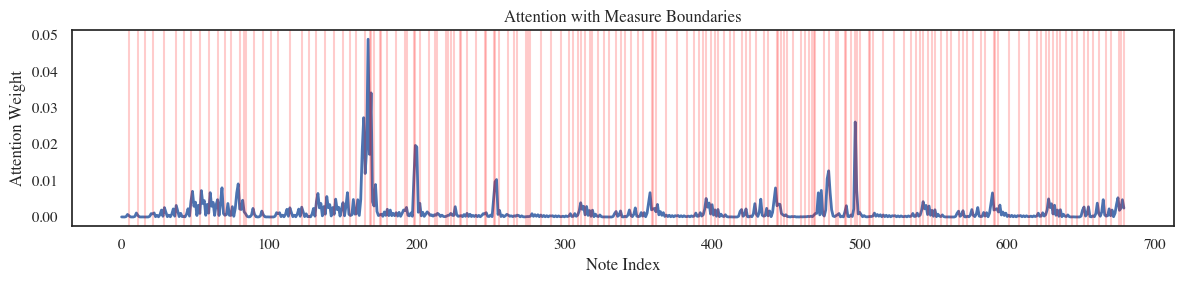

In [14]:
pm.plot_attention_over_time(
    attn_piece,
    title="Attention over Note Sequence"
)
pm.plot_attention_with_pitch(
    attn_piece,
    pcs_piece,
    pc_vocab_inv
)
pm.plot_attention_with_combined_pitch(
    attn_piece,
    pcs_piece,
    accs_piece,
    ai
)
pm.plot_attention_with_measures(attn_piece, meas_piece)